In [1]:
import sys
sys.path.append('../..')
import argparse
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from bundlenet_continuous_variant import BunDLeNet, train_model
from functions import preprocess_data, prep_data, plotting_neuronal_behavioural, plot_latent_timeseries, timeseries_train_test_split
from plotting_functions import plot_phase_space

import os
os.chdir('../..')

%reload_ext autoreload
%autoreload 2
os.getcwd()

2024-03-04 14:23:21.488957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 14:23:21.520251: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-04 14:23:21.520777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 14:23:22.065988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net'

## Load Data

In [2]:
fish_data_id = '220127_F4_F4_run2' #220119_F2_F2_run11, 220127_F4_F4_run2
path_neuronal_data ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_cells_spike_rate_signals.npy' 
path_behaviour_data1 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_directionality.npy'
path_behaviour_data2 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_vigour.npy'

In [3]:
X = np.load(path_neuronal_data).T
B1 = np.load(path_behaviour_data1)
B2 = np.load(path_behaviour_data2)
B = np.c_[B1, B2]

### Remove NaNs
B = B[~np.isnan(X[:,0])]
X = X[~np.isnan(X[:,0])]
B.shape, X.shape

### Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
B = StandardScaler(with_mean=False).fit_transform(B)
X = StandardScaler(with_mean=False).fit_transform(X)

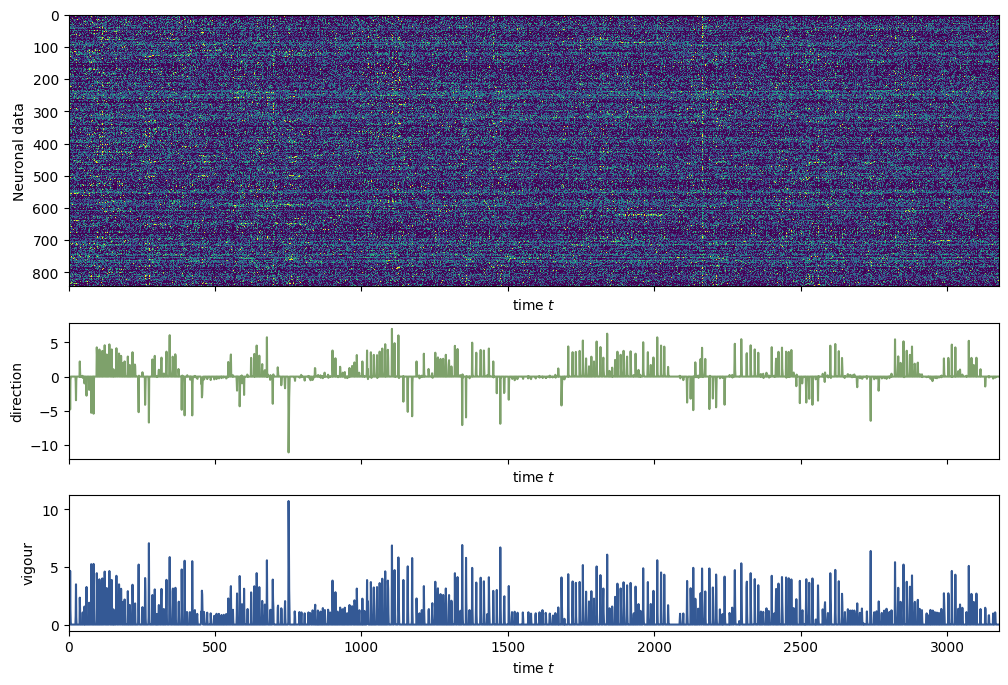

In [4]:
def plotting_neuronal_behavioural(X,B, state_names=[], **kwargs):
    fig, axs = plt.subplots(3,1,figsize=(12,8),  sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
    im0 = axs[0].imshow(X.T,aspect='auto', interpolation='None', **kwargs)
    # tell the colorbar to tick at integers
    axs[0].set_xlabel("time $t$")
    axs[0].set_ylabel("Neuronal data")
    
    colors = ['#7EA16B', '#345995', '#AF125A']
    ylabels = ['direction', 'vigour']
    for i in range(2):
        # Behaviour 1
        im1 = axs[i+1].plot(B[:,i], c=colors[i])
        axs[i+1].set_xlabel("time $t$")
        axs[i+1].set_ylabel(ylabels[i])
        #axs[i+1].set_yticks([])

    plt.show()
    
plotting_neuronal_behavioural(X,B, vmin=0, vmax=5)

## BunDLe-Net

In [5]:
models = []
history = []

for i in range(10):
    
    algorithm = 'BunDLeNet'
    X_, B_ = prep_data(X, B, win=1)

    ### Deploy BunDLe Net
    model = BunDLeNet(latent_dim=3, num_behaviour=B_.shape[1])
    model.build(input_shape=X_.shape)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

    X_train, X_test, B_train_1, B_test_1 = timeseries_train_test_split(X_, B_)
    train_history, test_history = train_model(
        X_train,
        B_train_1,
        model,
        optimizer,
        gamma=0.9, 
        n_epochs=200,
        pca_init=False,
        best_of_5_init=False,
        validation_data = (X_test, B_test_1)
    )
    
    models.append(model)
    history.append([train_history, test_history])

Loss [Markov, Behaviour, Total]: [0.0088 0.0432 0.052 ]: 100%|█| 200/200 [00:12<
Loss [Markov, Behaviour, Total]: [0.0023 0.0977 0.1   ]: 100%|█| 200/200 [00:12<
Loss [Markov, Behaviour, Total]: [0.0145 0.0084 0.0229]: 100%|█| 200/200 [00:11<
Loss [Markov, Behaviour, Total]: [0.0031 0.0978 0.1009]: 100%|█| 200/200 [00:11<
Loss [Markov, Behaviour, Total]: [0.0139 0.0081 0.022 ]: 100%|█| 200/200 [00:11<
Loss [Markov, Behaviour, Total]: [0.0175 0.0134 0.0309]: 100%|█| 200/200 [00:11<
Loss [Markov, Behaviour, Total]: [0.0144 0.0077 0.0221]: 100%|█| 200/200 [00:11<
Loss [Markov, Behaviour, Total]: [0.0179 0.0123 0.0302]: 100%|█| 200/200 [00:11<
Loss [Markov, Behaviour, Total]: [0.0148 0.0135 0.0283]: 100%|█| 200/200 [00:11<
Loss [Markov, Behaviour, Total]: [0.0138 0.0157 0.0296]: 100%|█| 200/200 [00:11<


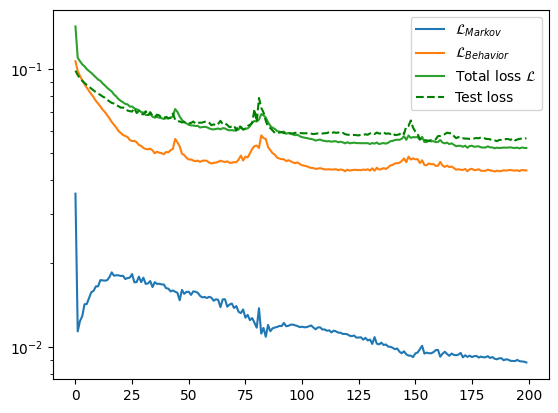

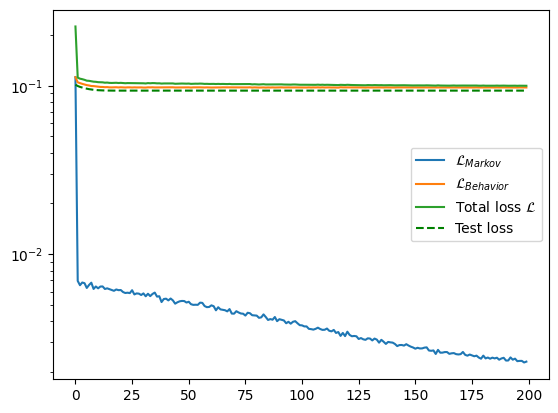

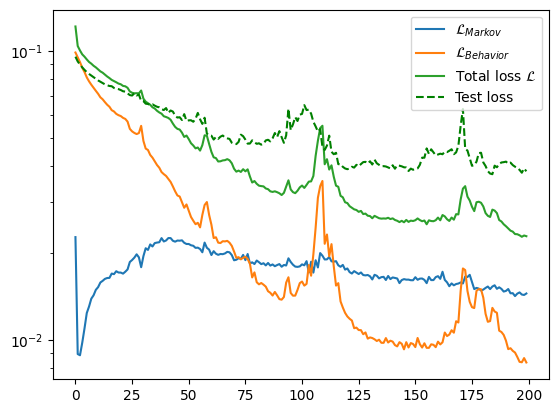

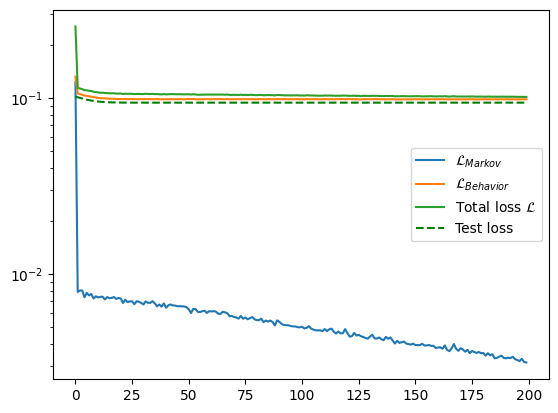

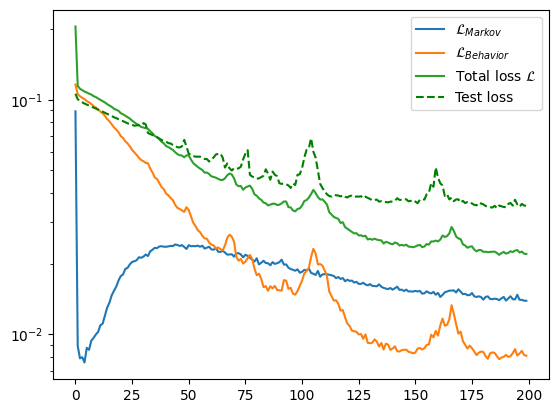

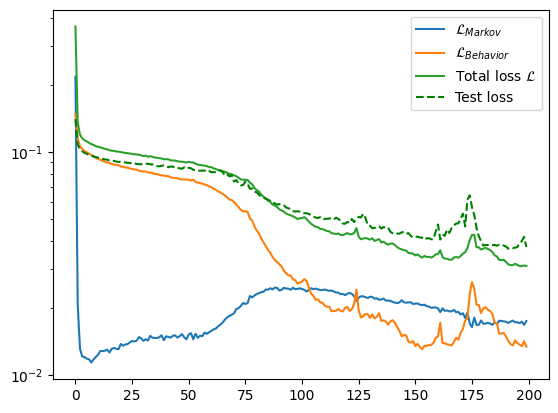

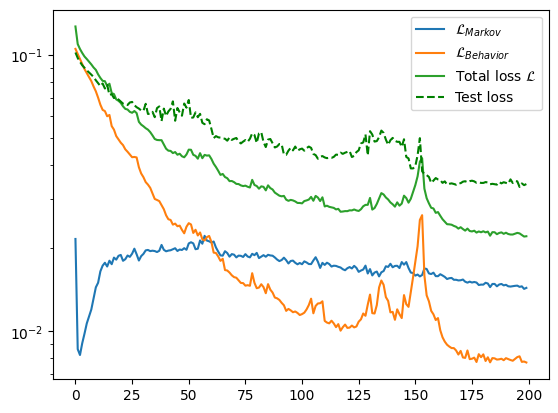

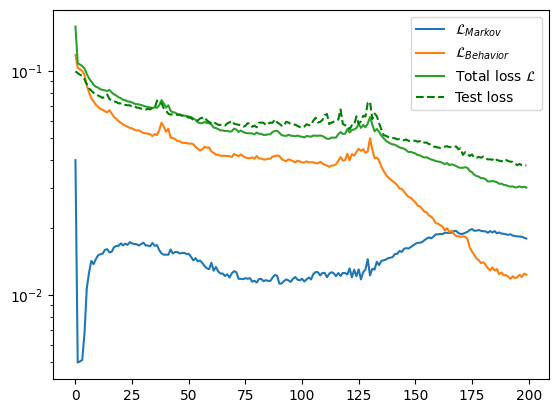

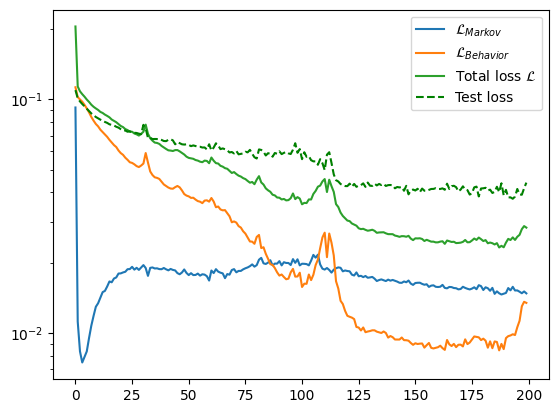

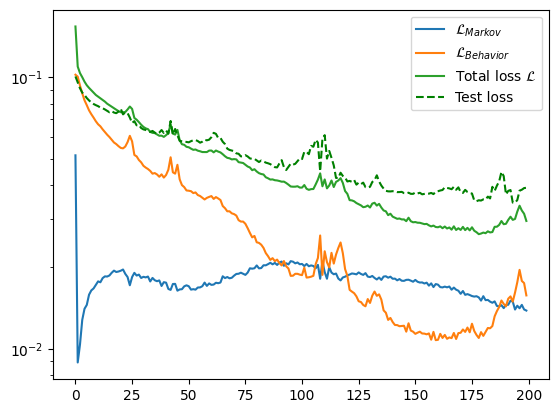

In [6]:
%matplotlib inline
for i, _ in enumerate(history):
    train_history = history[i][0] 
    test_history = history[i][1]
    # Training losses vs epochs
    plt.figure()
    for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
        plt.semilogy(train_history[:,i], label=label)

    plt.semilogy(test_history[:,-1], label="Test loss", linestyle="--", color='g')       
    plt.legend()
plt.show()


In [7]:
history = np.array(history)
train_loss = history[:,0,-1,-1]
test_loss = history[:,1,-1,-1]

model = models[np.argmin(test_loss)]

idx_optimal = np.argmin(test_loss)
model_opt = models[idx_optimal]
train_loss_opt = train_loss[idx_optimal]
test_loss_opt = test_loss[idx_optimal]
test_loss_opt

0.03411119244992733

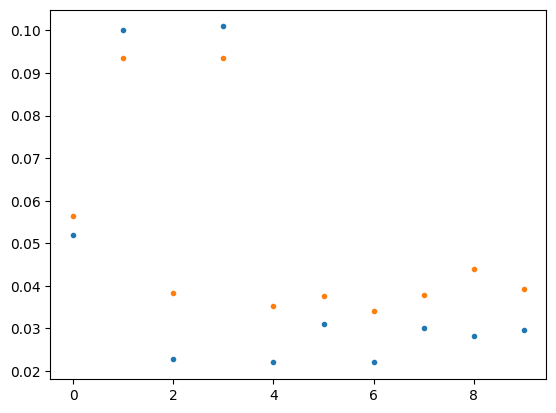

In [8]:
plt.figure()
plt.plot(train_loss, '.')
plt.plot(test_loss, '.')

## Projecting into latent space

In [109]:
### Projecting into latent space
Y0_ = model.tau(X_[:,0]).numpy()
Y0_.shape

(3175, 3)

In [9]:
os.getcwd()

'/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net'

In [13]:
def objective(config):

    models = []
    history = []

    X_, B_ = prep_data(X, B, win=config["win"])
    X_train, X_test, B_train_1, B_test_1 = timeseries_train_test_split(X_, B_)

    for i in range(5):
        T_Y_options  = {
            'linear': tf.keras.Sequential([
                layers.Dense(latent_dim, activation='linear'),
                layers.Normalization(axis=-1),
            ]),
            'non-linear': tf.keras.Sequential([
                layers.Dense(latent_dim, activation='relu'),
                layers.Dense(2*latent_dim, activation='relu'),
                layers.Dense(latent_dim, activation='linear'),
                layers.Normalization(axis=-1),
            ])
        }
        ### Deploy BunDLe Net
        model = BunDLeNet(latent_dim=3, num_behaviour=B_.shape[1])
        model.build(input_shape=X_.shape)
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
        model.T_Y = T_Y_options[config["T_Y_option"]]

        train_history, test_history = train_model(
            X_train,
            B_train_1,
            model,
            optimizer,
            gamma=0.9, 
            n_epochs=200,
            pca_init=False,
            best_of_5_init=False,
            validation_data = (X_test, B_test_1)
        )       
        models.append(model)
        history.append([train_history, test_history])

    # Choosing best model based on the test loss
    history = np.array(history)
    train_loss = history[:,0,-1,-1]
    test_loss = history[:,1,-1,-1]

    idx_optimal = np.argmin(test_loss)
    model_opt = models[idx_optimal]
    train_loss_opt = train_loss[idx_optimal]
    test_loss_opt = test_loss[idx_optimal]
    train.report({"test_loss":test_loss_opt, "train_loss":train_loss_opt})


In [68]:
from ray import tune, train
experiment_path = '~/ray_results/objective_2024-03-04_16-49-04' #objective_2024-03-04_14-36-44, objective_2024-03-04_16-06-50, objective_2024-03-04_16-49-04
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable=objective)
result_grid = restored_tuner.get_results()


Loading results from ~/ray_results/objective_2024-03-04_16-49-04...


<Axes: xlabel='config/win', ylabel='test_loss'>

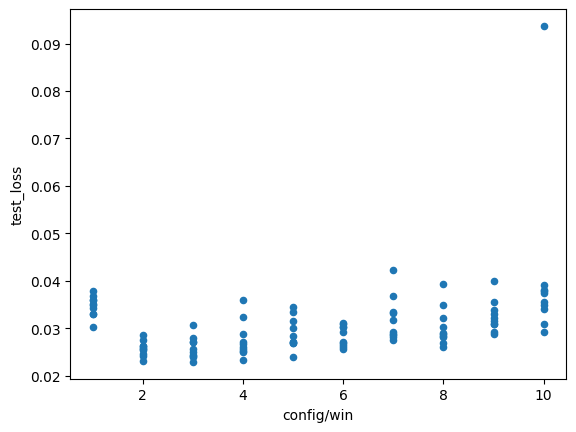

In [69]:
results_df = result_grid.get_dataframe()
df = results_df[[ 'config/win', 'config/T_Y_option', 'test_loss']]
results_df.plot.scatter(x='config/win', y= 'test_loss')

/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net/bundle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net/bundle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net/bundle_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net/bundle_env/lib/python3.9/sit

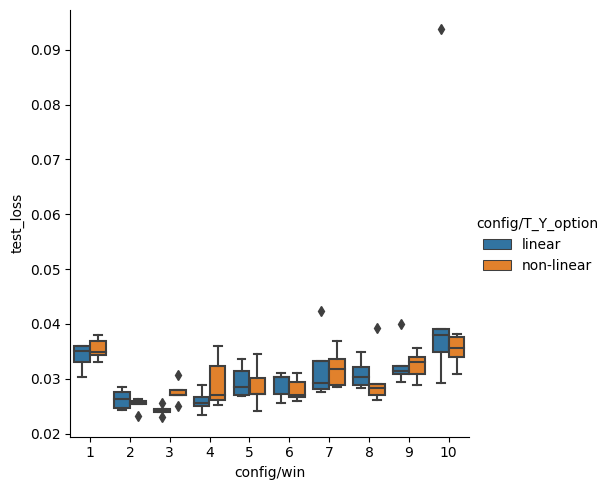

In [72]:
import seaborn as sns
sns.catplot(data=results_df, x='config/win', y='test_loss', hue='config/T_Y_option', kind='box')